In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
from extq import memory

In [2]:
sys.path.insert(1, "../../../python")
sys.path.insert(1, "../../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
# committors
lag = 500
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)

# Regular DGA w/ distance basis

In [6]:
d_down_arr = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/dist_down_3.npy")
d_up_arr = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/dist_up_3.npy")

In [8]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [20]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(~up_ids, traj_inds)
mask = ~up_ids

In [14]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make smoothing 0 in domain (up states for MFPT)
smooth[up_ids] = 0

In [16]:
basis_d = smooth * sb_arr
basis_d = np.split(basis_d, traj_inds)
basis_d = util.orthogonalize(basis_d, weights[0])

In [17]:
s = 20
N = len(cv_arr)
inds = random.sample(range(N), N // s)

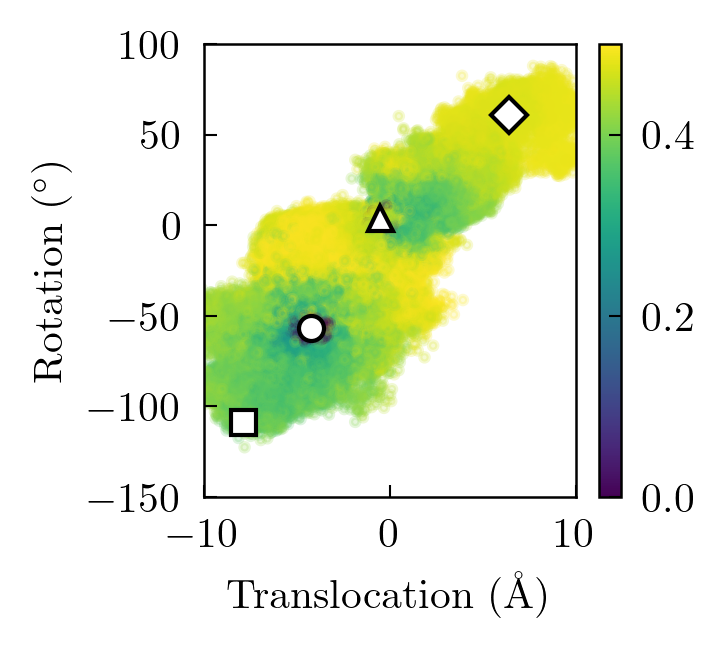

In [19]:
fig, ax = plt.subplots(dpi=300, figsize=(2, 2))
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2)

cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

In [25]:
len(weights)

10

In [29]:
# guess function: zeros
guess_mfpt = [np.zeros_like(traj) for traj in weights[0]]
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
mfpt_dga = []
for w, lag in zip(weights, lags):
    mfpt_dga.append(extq.dga.forward_mfpt(basis_d, w, in_domain, guess_mfpt, lag))

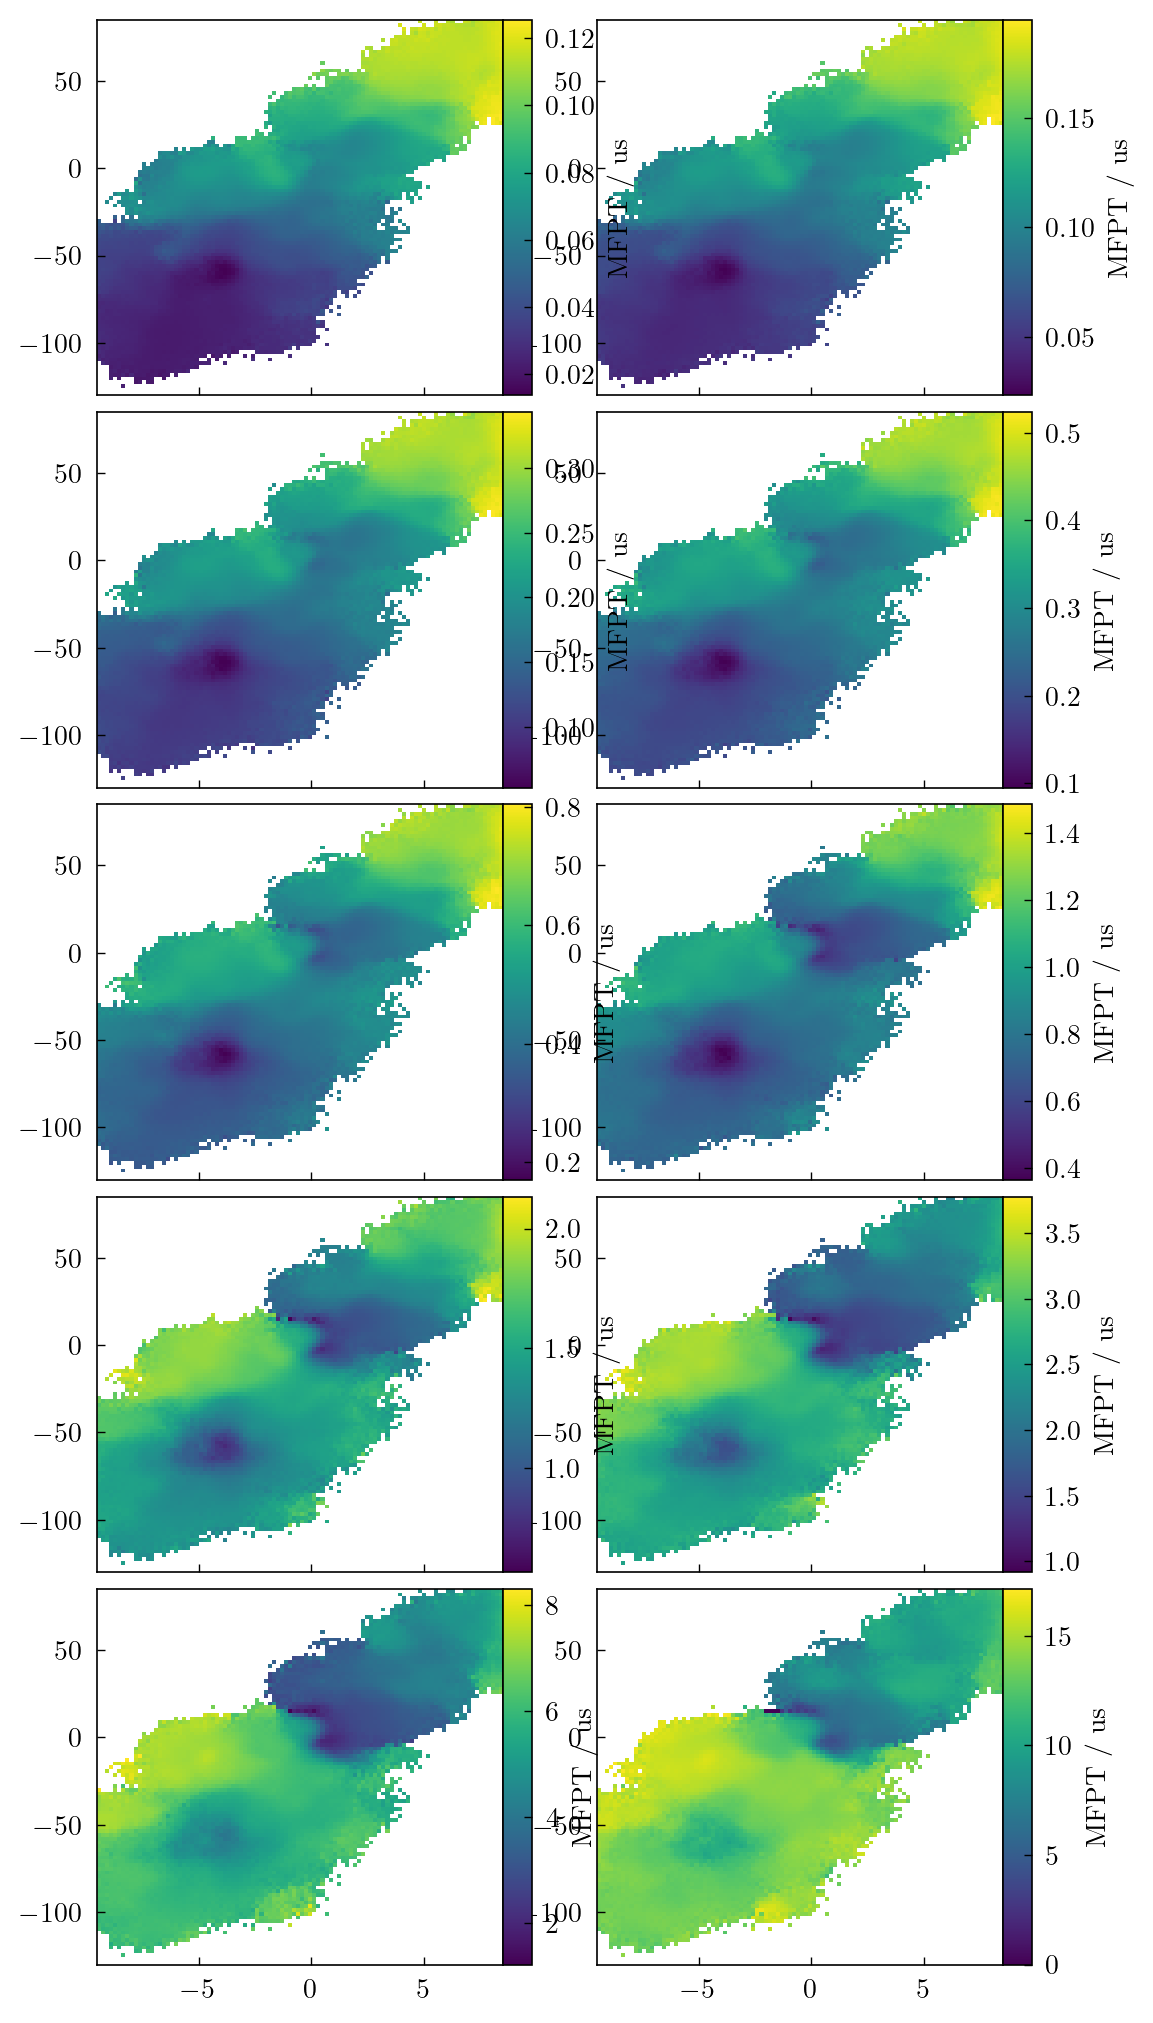

In [42]:
f, axs = plt.subplots(5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

for lag, m, w, ax in zip(lags, mfpt_dga, weights, axs.flat):
    dist_trajs = [t[:-lag, 0] for t in cv_trajs]
    rot_trajs = [t[:-lag, 1] for t in cv_trajs]
    w_delay = [t[:-lag] for t in w]
    mfpt_delay = []
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt_delay.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001)
    cb = pplt.colorbar(pc)
    cb.set_label("MFPT / us")

# Regular DGA w/ indicator basis

In [43]:
dtrajs_ivac = np.load(f"{DATA_DIR}/raw_feat/feat5_ivac_ind200_anton2_3.npy")
basis_d_arr = util.make_sparse_basis(np.squeeze(dtrajs_ivac))
basis_d_arr[up_ids] = 0

traj_lens = [len(traj) for traj in cv_trajs]
basis_d = []
curr = 0
for t_len in traj_lens:
    basis_d.append(basis_d_arr[curr : curr + t_len])
    curr += t_len

/home/scguo/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [45]:
# guess function: zeros
guess_mfpt = [np.zeros_like(traj) for traj in weights[0]]
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
mfpt_dga_ind = []
for w, lag in zip(weights, lags):
    mfpt_dga_ind.append(extq.dga.forward_mfpt(basis_d, w, in_domain, guess_mfpt, lag))

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


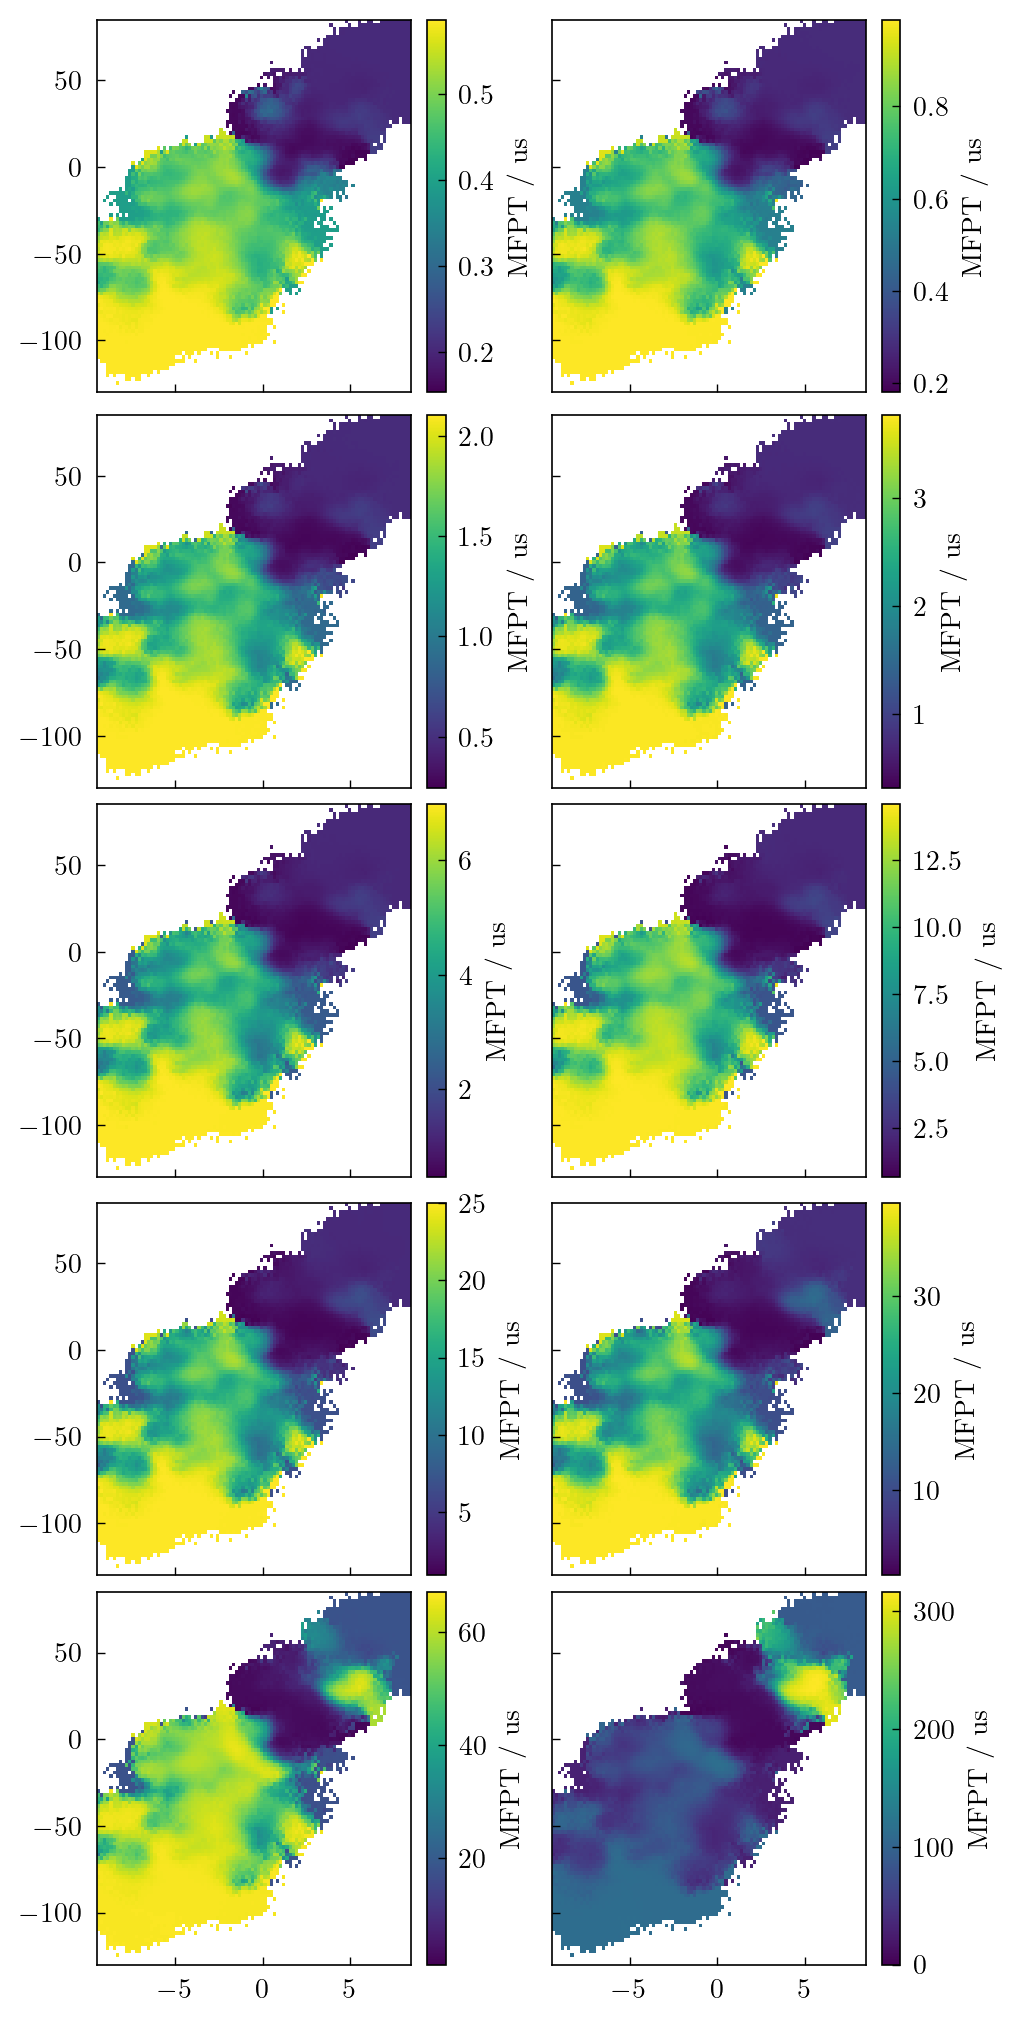

In [47]:
f, axs = plt.subplots(5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

for lag, m, w, ax in zip(lags, mfpt_dga_ind, weights, axs.flat):
    dist_trajs = [t[:-lag, 0] for t in cv_trajs]
    rot_trajs = [t[:-lag, 1] for t in cv_trajs]
    w_delay = [t[:-lag] for t in w]
    mfpt_delay = []
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt_delay.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001)
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label("MFPT / us")

In [51]:
# lag 200 (20 ns)
mfpt_down = np.concatenate(mfpt_dga_ind[7])[down_ids]
weight_down = np.concatenate(weights[0])[down_ids]
print(np.mean(mfpt_down) * 0.0001)
print(np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down))

32.465493486244235
32.49773204075616


In [52]:
# lag 500 (50 ns)
mfpt_down = np.concatenate(mfpt_dga_ind[8])[down_ids]
weight_down = np.concatenate(weights[0])[down_ids]
print(np.mean(mfpt_down) * 0.0001)
print(np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down))

54.41509477913393
54.468709044132495


# With memory

In [58]:
test = extq.memory.forward_mfpt(basis_d, weights[7], in_domain, guess_mfpt, 200, mem=3)

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


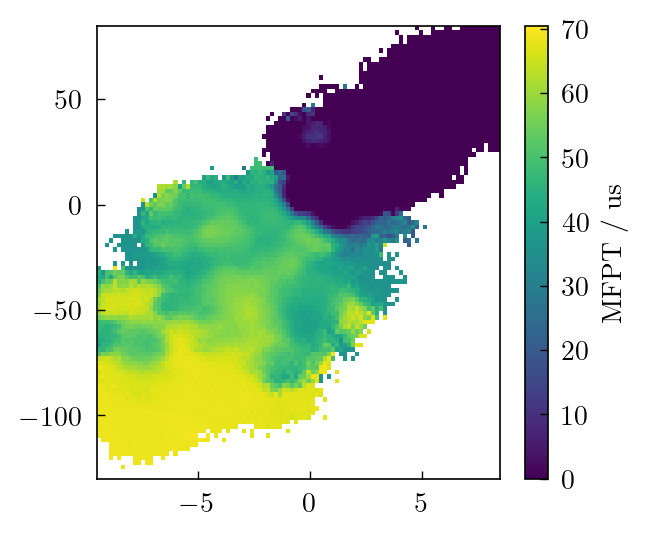

In [59]:
fig = plt.figure(figsize=(3.25, 3), dpi=200)
ax = plt.gca()
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

lag = 200
dist_trajs = [t[:-lag, 0] for t in cv_trajs]
rot_trajs = [t[:-lag, 1] for t in cv_trajs]
w_delay = [t[:-lag] for t in weights[7]]
mfpt_delay = []
for d, t in zip(in_domain, test):
    stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
    mfpt_delay.append(t[stop_times])
mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001, vmin=0)
cb = plt.colorbar(pc, ax=ax)
cb.set_label("MFPT / us")

In [64]:
memlags = [(5, 1), (6, 1), (6, 3), (7, 1), (7, 3), (8, 1), (8, 3), (8, 4), (9, 1), (9, 3), (9, 4), (9, 9)]
results = {}
for lagid, mem in memlags:
    print(f"Computing MFPT for lag {lags[lagid]} and mem {mem}")
    ans = extq.memory.forward_mfpt(basis_d, weights[lagid], in_domain, guess_mfpt, lags[lagid], mem=mem)
    results[lags[lagid], mem] = ans

Computing MFPT for lag 50 and mem 1
Computing MFPT for lag 100 and mem 1
Computing MFPT for lag 100 and mem 3
Computing MFPT for lag 200 and mem 1
Computing MFPT for lag 200 and mem 3
Computing MFPT for lag 500 and mem 1
Computing MFPT for lag 500 and mem 3
Computing MFPT for lag 500 and mem 4
Computing MFPT for lag 1000 and mem 1
Computing MFPT for lag 1000 and mem 3
Computing MFPT for lag 1000 and mem 4
Computing MFPT for lag 1000 and mem 9


In [65]:
len(memlags)

12

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


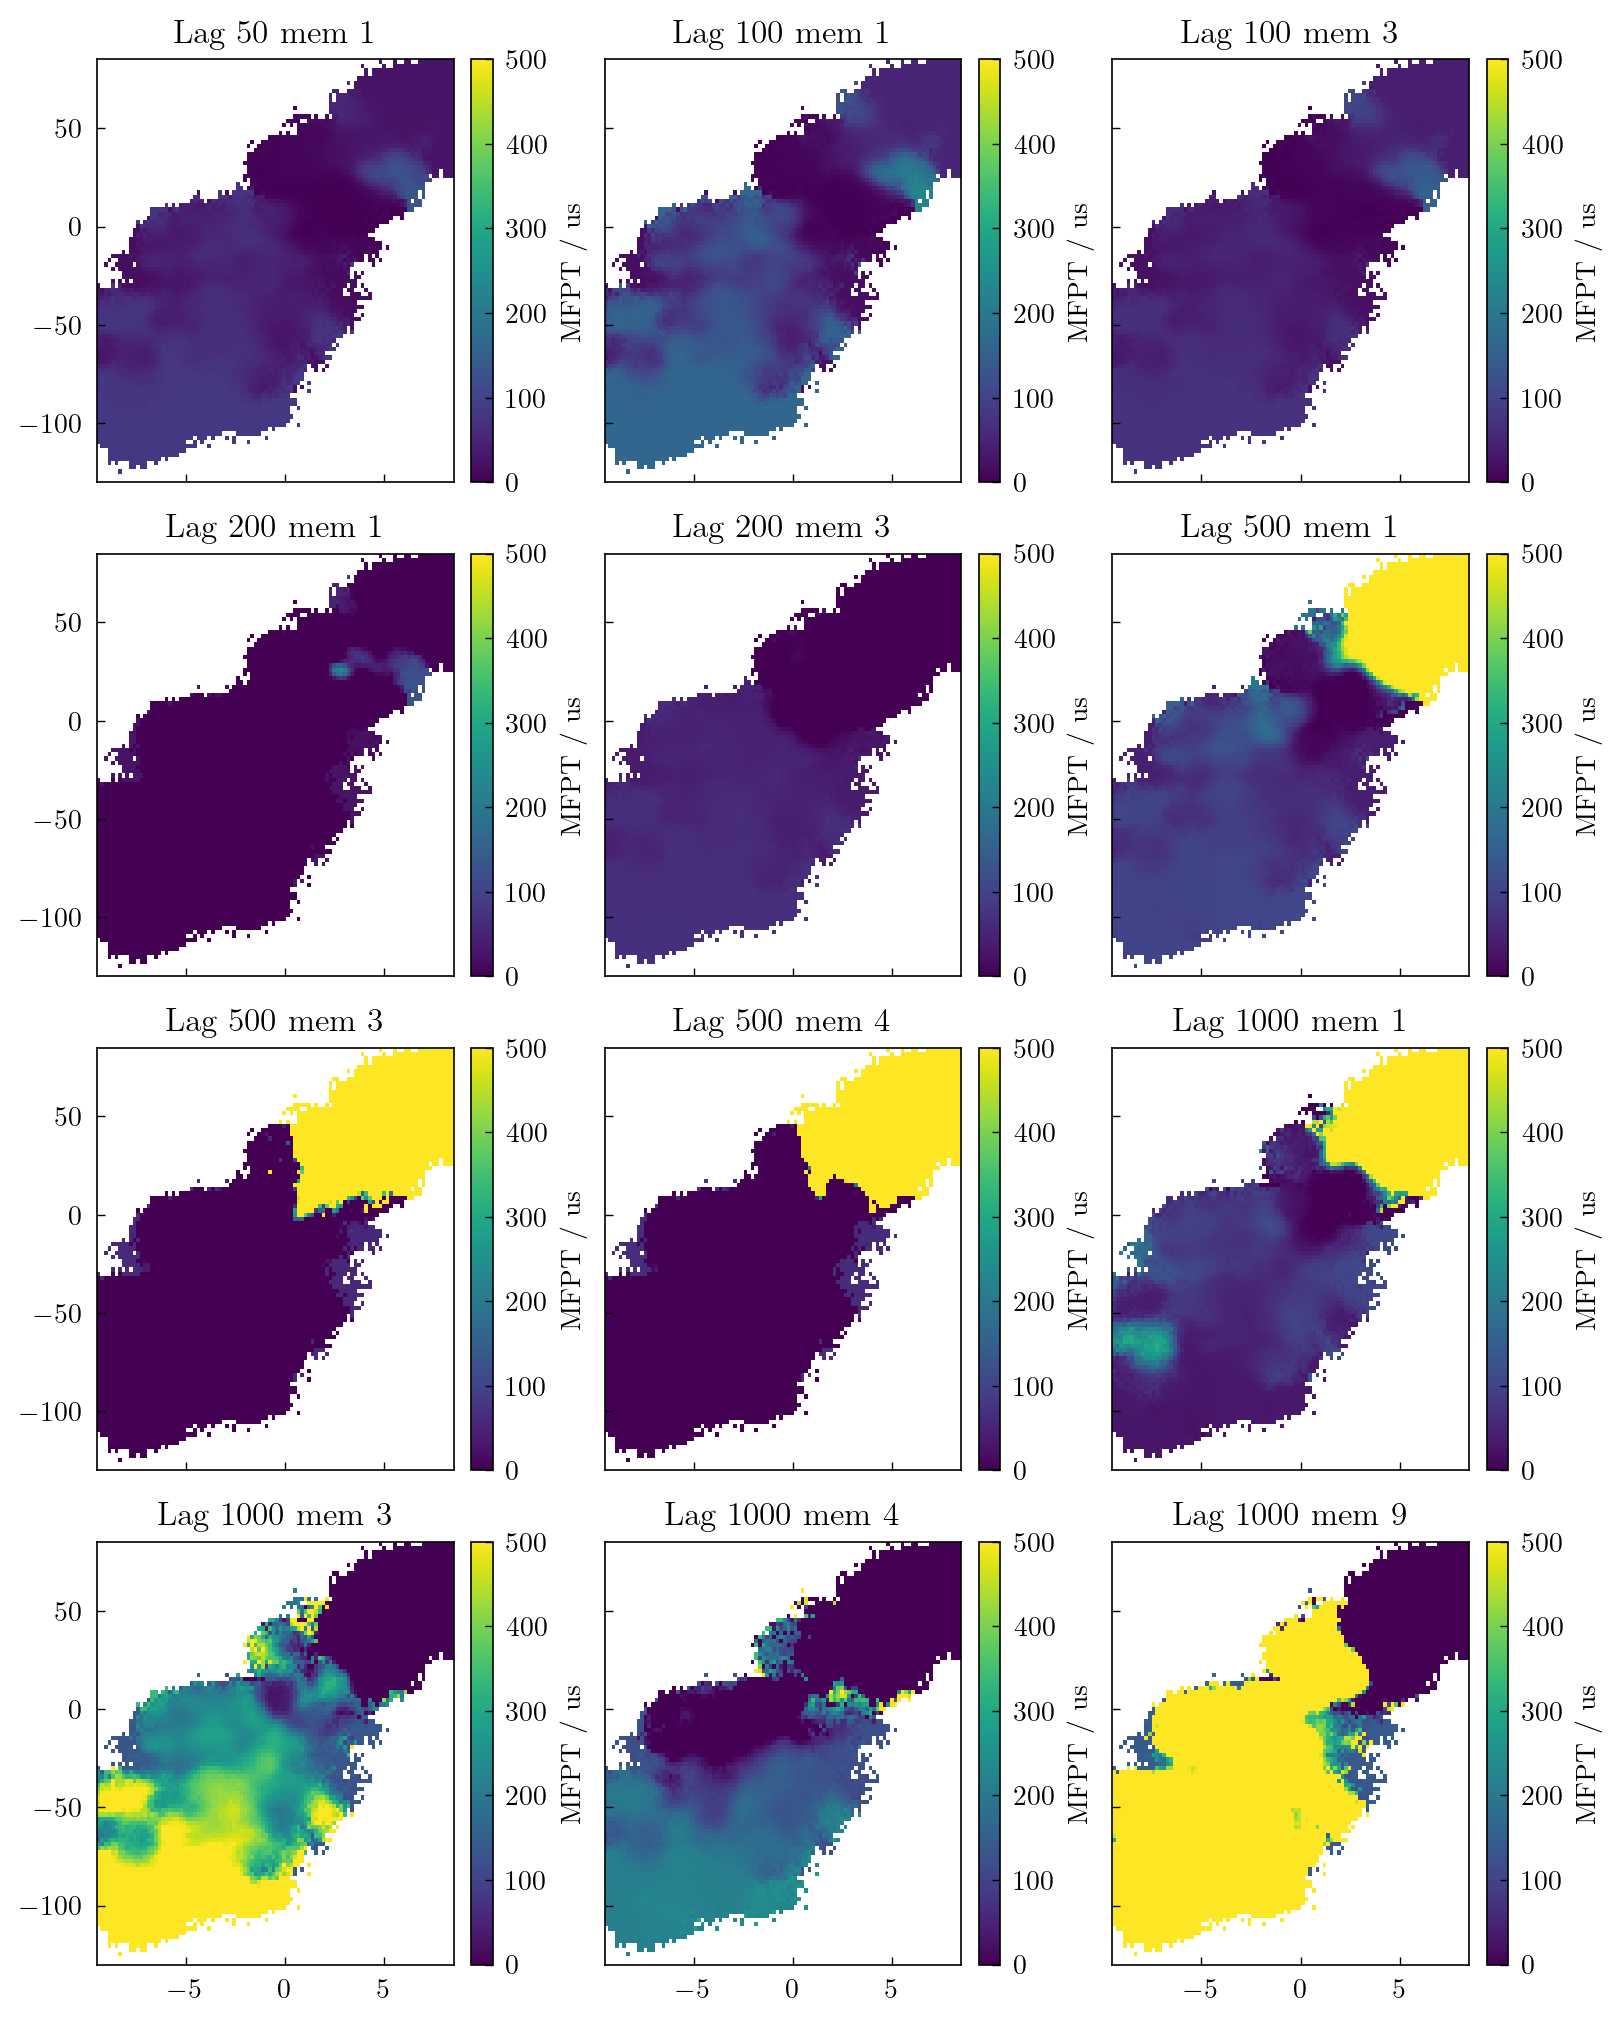

In [68]:
f, axs = plt.subplots(4, 3, figsize=(8, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

for (lag, mem), m, ax in zip(results.keys(), results.values(), axs.flat):
    dist_trajs = [t[:-lag, 0] for t in cv_trajs]
    rot_trajs = [t[:-lag, 1] for t in cv_trajs]
    w_delay = [t[:-lag] for t in weights[0]]
    mfpt_delay = []
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt_delay.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001, vmin=0, vmax=500)
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label("MFPT / us")
    ax.set_title(f"Lag {lag} mem {mem}")

In [70]:
for (lag, mem), m in zip(results.keys(), results.values()):
    print(f"Lag {lag} mem {mem}")
    mfpt_down = np.concatenate(m)[down_ids]
    weight_down = np.concatenate(weights[0])[down_ids]
    print(np.mean(mfpt_down) * 0.0001)
    print(np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down))

Lag 50 mem 1
64.3009733501888
64.37153995773158
Lag 100 mem 1
129.3235439277306
129.4845925263228
Lag 100 mem 3
57.94058236079393
57.99520199462656
Lag 200 mem 1
-42893.14633000285
-42955.38952542701
Lag 200 mem 3
58.287341163107605
58.319484299821966
Lag 500 mem 1
96.63895396236056
96.70898521539942
Lag 500 mem 3
-926.1470348154448
-927.579196963487
Lag 500 mem 4
-2092.3087255495548
-2095.4321798359083
Lag 1000 mem 1
55.12390030988952
55.032544785840365
Lag 1000 mem 3
413.57675397387857
413.987210976612
Lag 1000 mem 4
110.4809891052767
110.4814873590548
Lag 1000 mem 9
1625.1049610086402
1627.2391583291062


## Try different indicator basis

In [71]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import ivac

In [76]:
# reduce dimensions with IVAC
livac = ivac.LinearIVAC(minlag=10, maxlag=1000, nevecs=10, reweight=False, adjust=True)
livac.fit(sb_trajs)
ivac_trajs = livac.transform(sb_trajs)

ivac_arr = np.concatenate(ivac_trajs)
print(ivac_arr.shape)

(4150115, 10)


In [77]:
np.save(f"{DATA_DIR}/raw_feat/feat2_ivac_anton2_10-1000.npy", ivac_trajs)

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [80]:
# cluster IVAC points with K-means
km_ivac = MiniBatchKMeans(n_clusters=200)
km_ivac.fit(ivac_arr)

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=200)

In [81]:
centers = km_ivac.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [83]:
dtrajs_ivac = neighbors.kneighbors(ivac_arr, return_distance=False)

In [84]:
np.save(f"{DATA_DIR}/raw_feat/feat2_ivac_anton2_10-1000_ind200.npy", dtrajs_ivac)

In [85]:
basis_d_arr = util.make_sparse_basis(np.squeeze(dtrajs_ivac))
basis_d_arr[up_ids] = 0

traj_lens = [len(traj) for traj in cv_trajs]
basis_d = []
curr = 0
for t_len in traj_lens:
    basis_d.append(basis_d_arr[curr : curr + t_len])
    curr += t_len

/home/scguo/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [86]:
# guess function: zeros
guess_mfpt = [np.zeros_like(traj) for traj in weights[0]]
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
mfpt_dga_ind = []
for w, lag in zip(weights, lags):
    mfpt_dga_ind.append(extq.dga.forward_mfpt(basis_d, w, in_domain, guess_mfpt, lag))

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


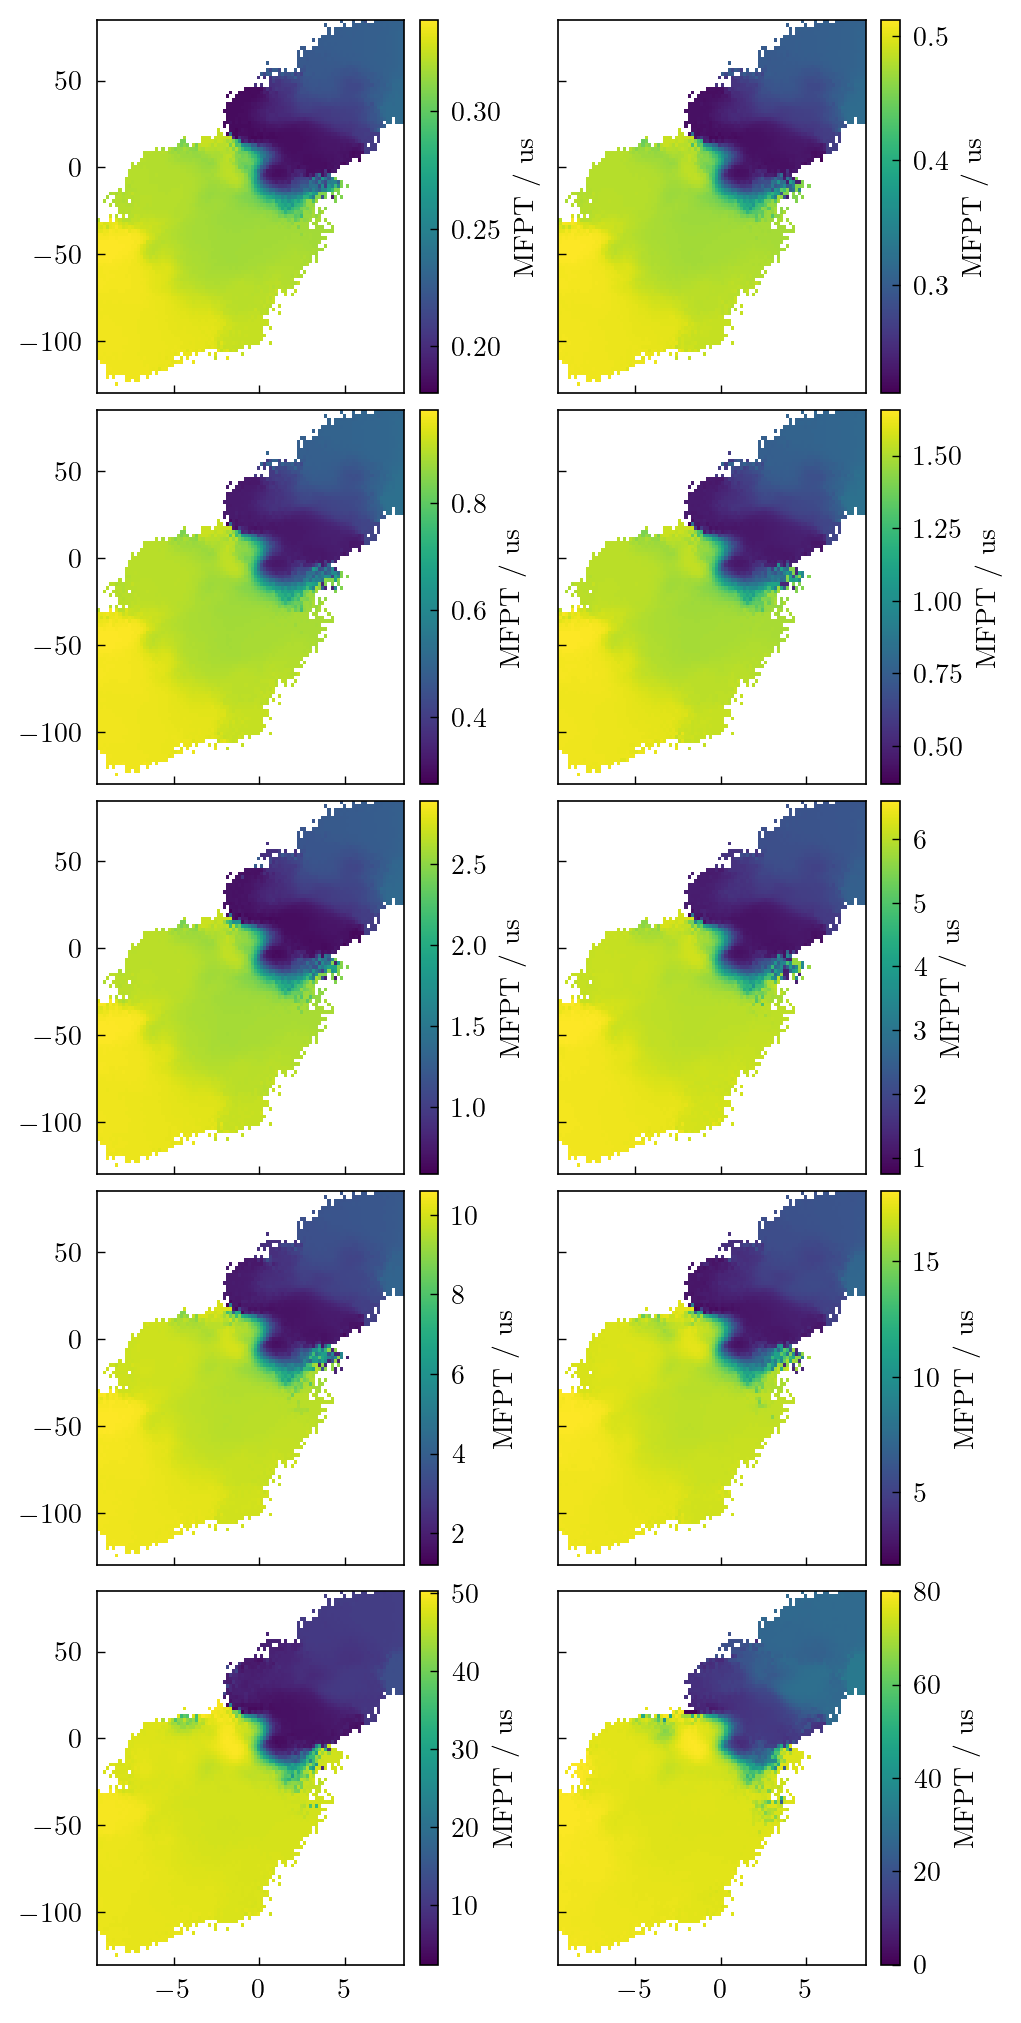

In [87]:
f, axs = plt.subplots(5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

for lag, m, w, ax in zip(lags, mfpt_dga_ind, weights, axs.flat):
    dist_trajs = [t[:-lag, 0] for t in cv_trajs]
    rot_trajs = [t[:-lag, 1] for t in cv_trajs]
    w_delay = [t[:-lag] for t in w]
    mfpt_delay = []
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt_delay.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001)
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label("MFPT / us")

In [91]:
for lag, m in zip(lags, mfpt_dga_ind):
    print(f"Lag {lag}")
    mfpt_down = np.concatenate(m)[down_ids]
    weight_down = np.concatenate(weights[0])[down_ids]
    print(f"{np.mean(mfpt_down) * 0.0001:>.2f}")
    print(f"{np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down):>.2f}")

Lag 1
0.32
0.32
Lag 2
0.48
0.48
Lag 5
0.89
0.89
Lag 10
1.50
1.50
Lag 20
2.62
2.62
Lag 50
6.05
6.05
Lag 100
9.71
9.71
Lag 200
16.62
16.62
Lag 500
47.17
47.17
Lag 1000
76.09
76.09


In [92]:
memlags = [(5, 1), (6, 1), (6, 3), (7, 1), (7, 3), (8, 1), (8, 3), (8, 4), (9, 1), (9, 3), (9, 4), (9, 9)]
results = {}
for lagid, mem in memlags:
    print(f"Computing MFPT for lag {lags[lagid]} and mem {mem}")
    ans = extq.memory.forward_mfpt(basis_d, weights[lagid], in_domain, guess_mfpt, lags[lagid], mem=mem)
    results[lags[lagid], mem] = ans

Computing MFPT for lag 50 and mem 1
Computing MFPT for lag 100 and mem 1
Computing MFPT for lag 100 and mem 3
Computing MFPT for lag 200 and mem 1
Computing MFPT for lag 200 and mem 3
Computing MFPT for lag 500 and mem 1
Computing MFPT for lag 500 and mem 3
Computing MFPT for lag 500 and mem 4
Computing MFPT for lag 1000 and mem 1
Computing MFPT for lag 1000 and mem 3
Computing MFPT for lag 1000 and mem 4
Computing MFPT for lag 1000 and mem 9


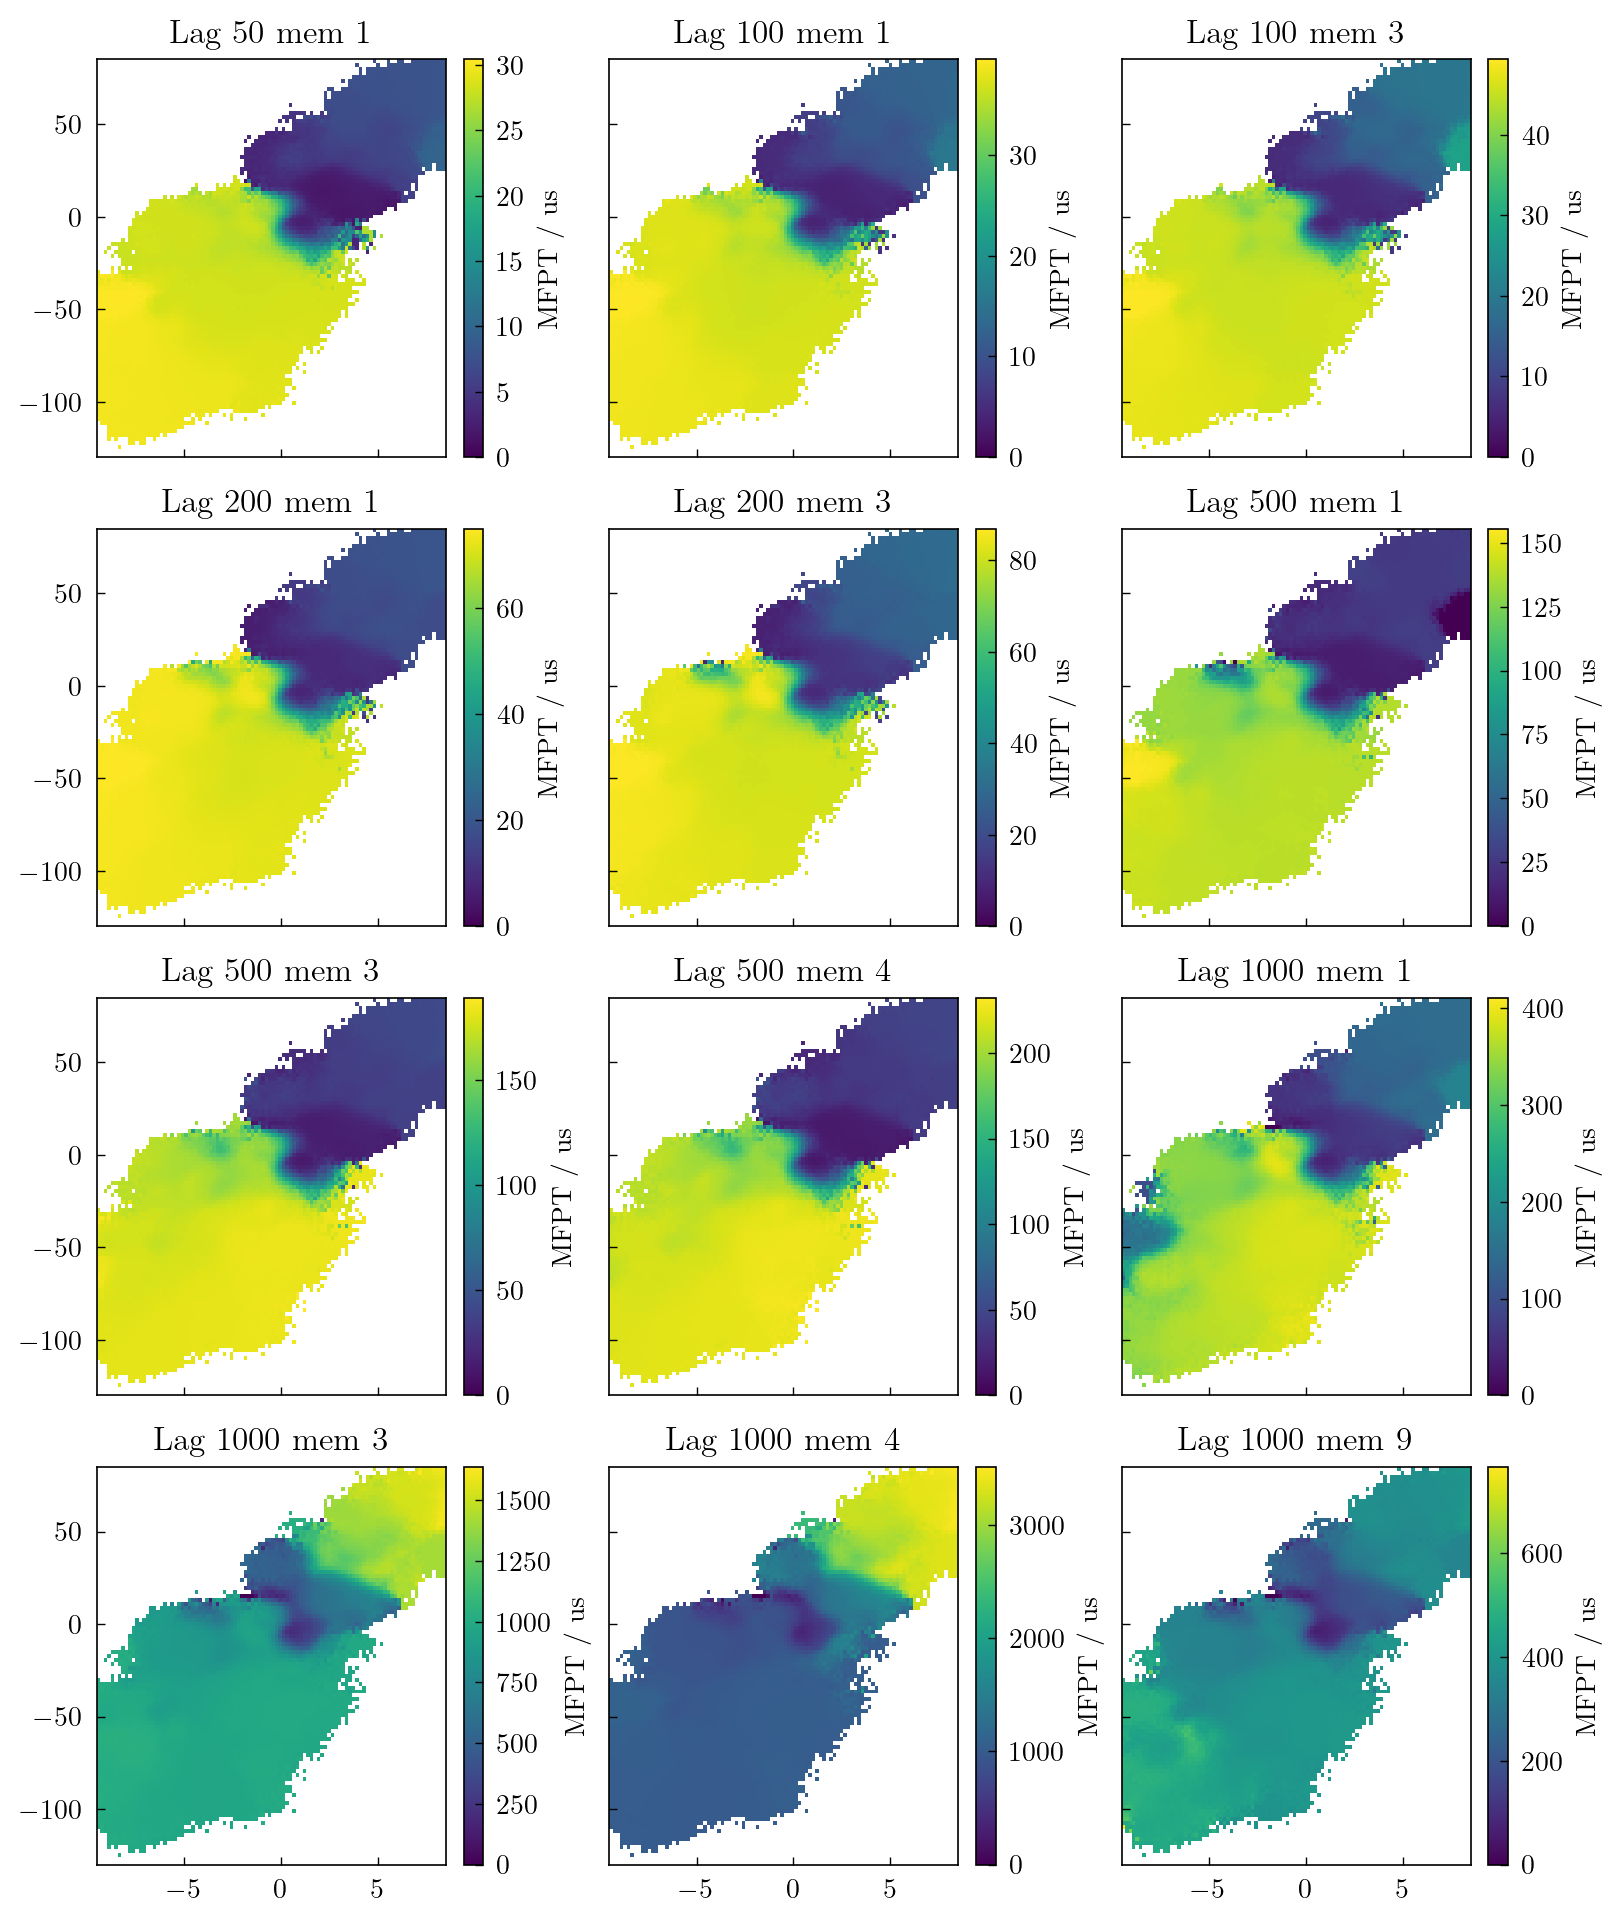

In [95]:
f, axs = plt.subplots(4, 3, figsize=(8, 9.5), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

for (lag, mem), m, ax in zip(results.keys(), results.values(), axs.flat):
    dist_trajs = [t[:-lag, 0] for t in cv_trajs]
    rot_trajs = [t[:-lag, 1] for t in cv_trajs]
    w_delay = [t[:-lag] for t in weights[0]]
    mfpt_delay = []
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt_delay.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001, vmin=0)
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label("MFPT / us")
    ax.set_title(f"Lag {lag} mem {mem}")

In [94]:
for (lag, mem), m in zip(results.keys(), results.values()):
    print(f"Lag {lag} mem {mem}")
    mfpt_down = np.concatenate(m)[down_ids]
    weight_down = np.concatenate(weights[0])[down_ids]
    print(np.mean(mfpt_down) * 0.0001)
    print(np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down))

Lag 50 mem 1
28.485203492934847
28.485343890354986
Lag 100 mem 1
36.850781142355466
36.85084080952372
Lag 100 mem 3
45.42653599512754
45.42676907539304
Lag 200 mem 1
71.29544163620582
71.29538164740968
Lag 200 mem 3
81.56461168928979
81.56516373804371
Lag 500 mem 1
136.9229708385761
136.92404764803754
Lag 500 mem 3
179.3232158219727
179.32273307744993
Lag 500 mem 4
218.68250150677767
218.6851594578485
Lag 1000 mem 1
370.7794067140303
370.78487687880397
Lag 1000 mem 3
948.4179639451769
948.4411131795982
Lag 1000 mem 4
986.5560029542863
986.5785055769187
Lag 1000 mem 9
383.21774001219825
383.24331407012755


# Try different states with indicator basis

In [5]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# Any points less than
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
# down_ids_square = (dist < -4.24) & (rot < -56.95)
zero = np.zeros_like(dist)
dist_ax_down = np.maximum(dist + 4.240, zero) / 1.1
rot_ax_down = np.maximum(rot + 56.95, zero) / 8
down_ids = ((dist_ax_down**2 + rot_ax_down**2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
# include points cut out by salt bridges outside of
down_ids_alt = (dist < -5.34) & (rot < -64.95) & ~down_ids
down_ids = down_ids | down_ids_alt

# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
dist_ax_up = np.minimum(dist + 0.506, zero) / 0.84
rot_ax_up = np.minimum(rot - 3.94, zero) / 7.6
up_ids = ((dist_ax_up**2 + rot_ax_up**2) < 1) & (sb1 < 0.5) & (sb3 < 1.1) & (sb4 < 0.75) & (sb5 < 0.6)
up_ids_alt = (dist > 0.334) & (rot > 11.5) & ~up_ids
up_ids = up_ids | up_ids_alt

In [6]:
dtrajs_ivac = np.load(f"{DATA_DIR}/raw_feat/feat2_ivac_anton2_10-1000_ind200.npy")

In [7]:
basis_d_arr = util.make_dense_basis(np.squeeze(dtrajs_ivac))
basis_d_arr[up_ids] = 0

In [8]:
mask = np.any(basis_d_arr != 0.0, axis=0)
basis_d_arr = basis_d_arr[:, mask]

In [9]:
traj_lens = [len(traj) for traj in cv_trajs]
basis_d = []
curr = 0
for t_len in traj_lens:
    basis_d.append(scipy.sparse.csr_matrix(basis_d_arr[curr : curr + t_len]))
    curr += t_len

In [10]:
# guess function: zeros
guess_mfpt = [np.zeros_like(traj) for traj in weights[0]]
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(~up_ids, traj_inds)
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
mfpt_dga_ind = []
for w, lag in zip(weights, lags):
    mfpt_dga_ind.append(extq.dga.forward_mfpt(basis_d, w, in_domain, guess_mfpt, lag))

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


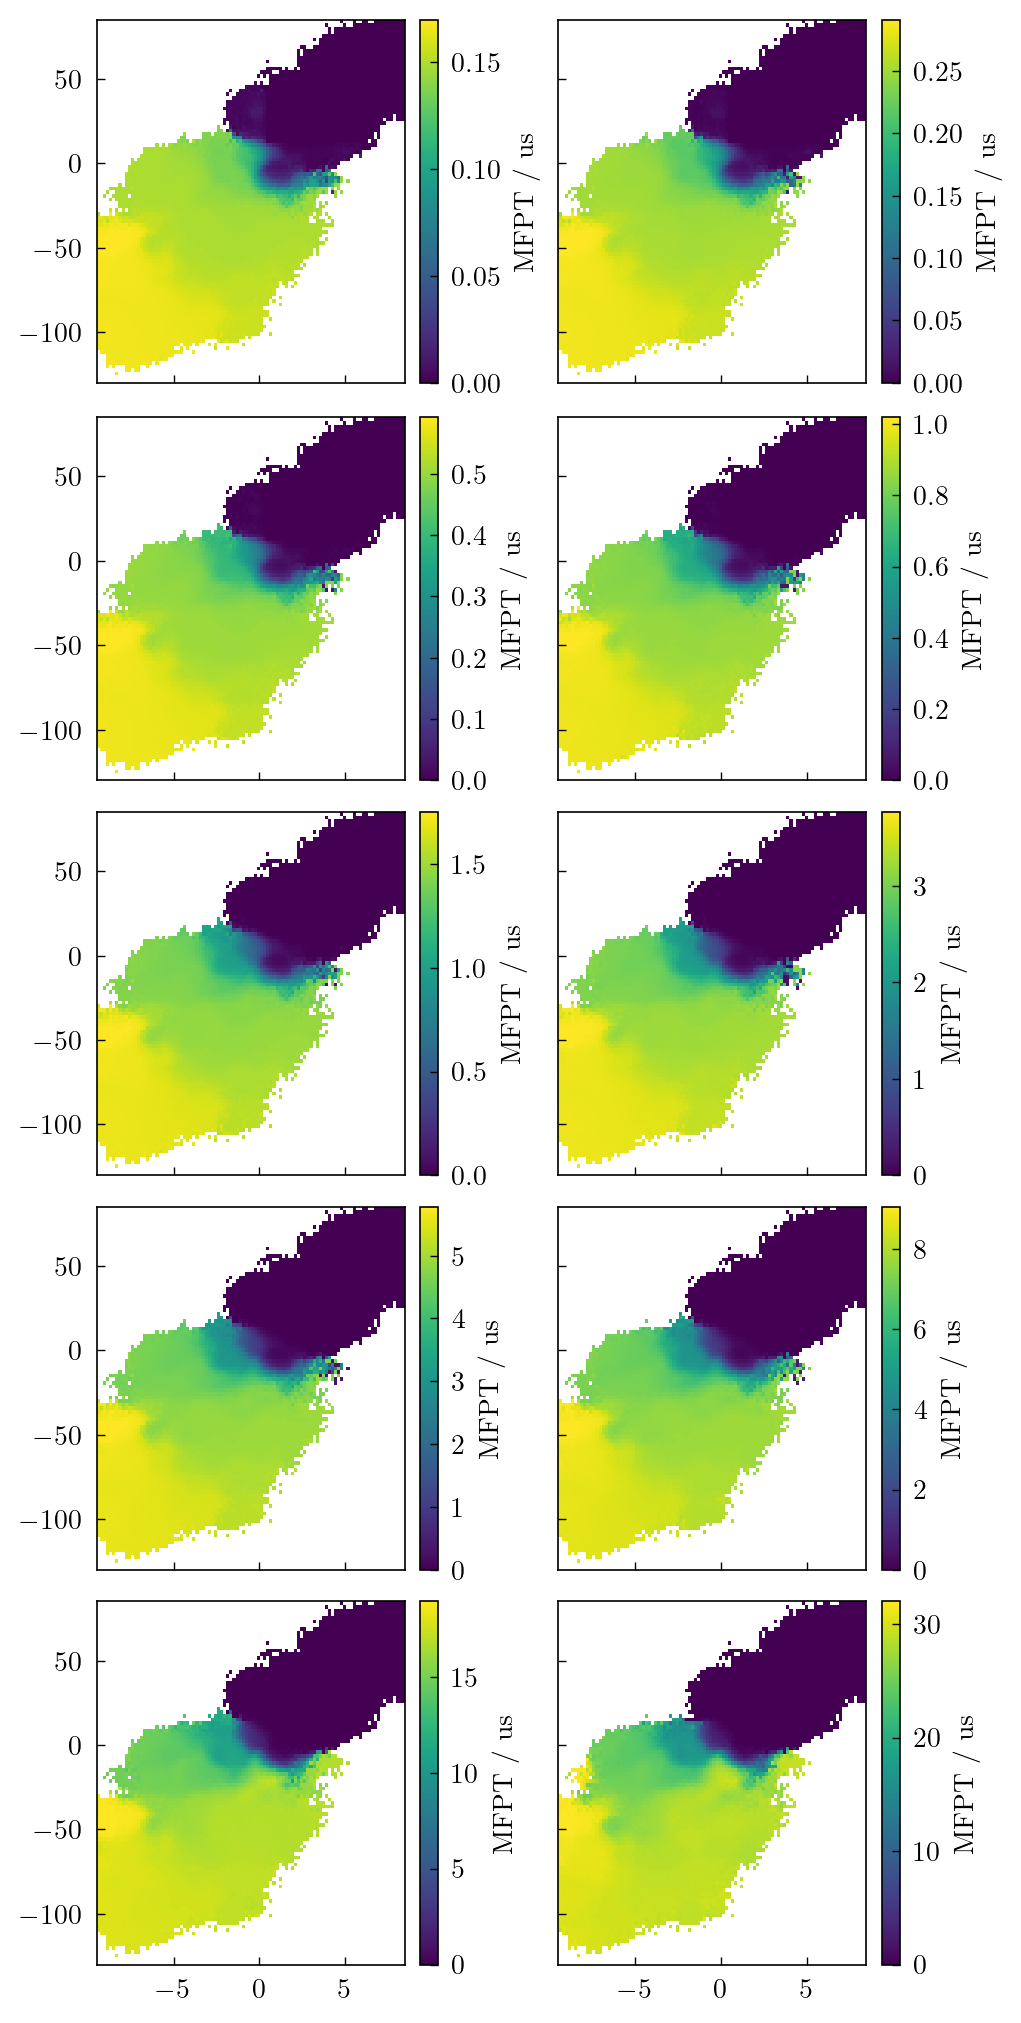

In [18]:
f, axs = plt.subplots(5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

for lag, m, w, ax in zip(lags, mfpt_dga_ind, weights, axs.flat):
    dist_trajs = [t[:-lag, 0] for t in cv_trajs]
    rot_trajs = [t[:-lag, 1] for t in cv_trajs]
    w_delay = [t[:-lag] for t in w]
    mfpt_delay = []
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt_delay.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001)
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label("MFPT / us")

In [19]:
for lag, m in zip(lags, mfpt_dga_ind):
    print(f"Lag {lag}")
    mfpt_down = np.concatenate(m)[down_ids]
    weight_down = np.concatenate(weights[0])[down_ids]
    print(f"{np.mean(mfpt_down) * 0.0001:>.2f}")
    print(f"{np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down):>.2f}")

Lag 1
0.16
0.16
Lag 2
0.28
0.28
Lag 5
0.56
0.56
Lag 10
0.96
0.96
Lag 20
1.64
1.64
Lag 50
3.54
3.54
Lag 100
5.38
5.38
Lag 200
8.39
8.39
Lag 500
17.49
17.49
Lag 1000
29.49
29.49


In [ ]:
memlags = [(5, 1), (6, 1), (6, 3), (7, 1), (7, 3), (8, 1), (8, 3), (8, 4), (9, 1), (9, 3)]
results = {}
for lagid, mem in memlags:
    print(f"Computing MFPT for lag {lags[lagid]} and mem {mem}")
    ans = extq.memory.forward_mfpt(basis_d, weights[lagid], in_domain, guess_mfpt, lags[lagid], mem=mem)
    results[lags[lagid], mem] = ans

Computing MFPT for lag 50 and mem 1
Computing MFPT for lag 100 and mem 1
Computing MFPT for lag 100 and mem 3
Computing MFPT for lag 200 and mem 1
Computing MFPT for lag 200 and mem 3
Computing MFPT for lag 500 and mem 1
Computing MFPT for lag 500 and mem 3
Computing MFPT for lag 500 and mem 4
Computing MFPT for lag 1000 and mem 1
Computing MFPT for lag 1000 and mem 3


/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


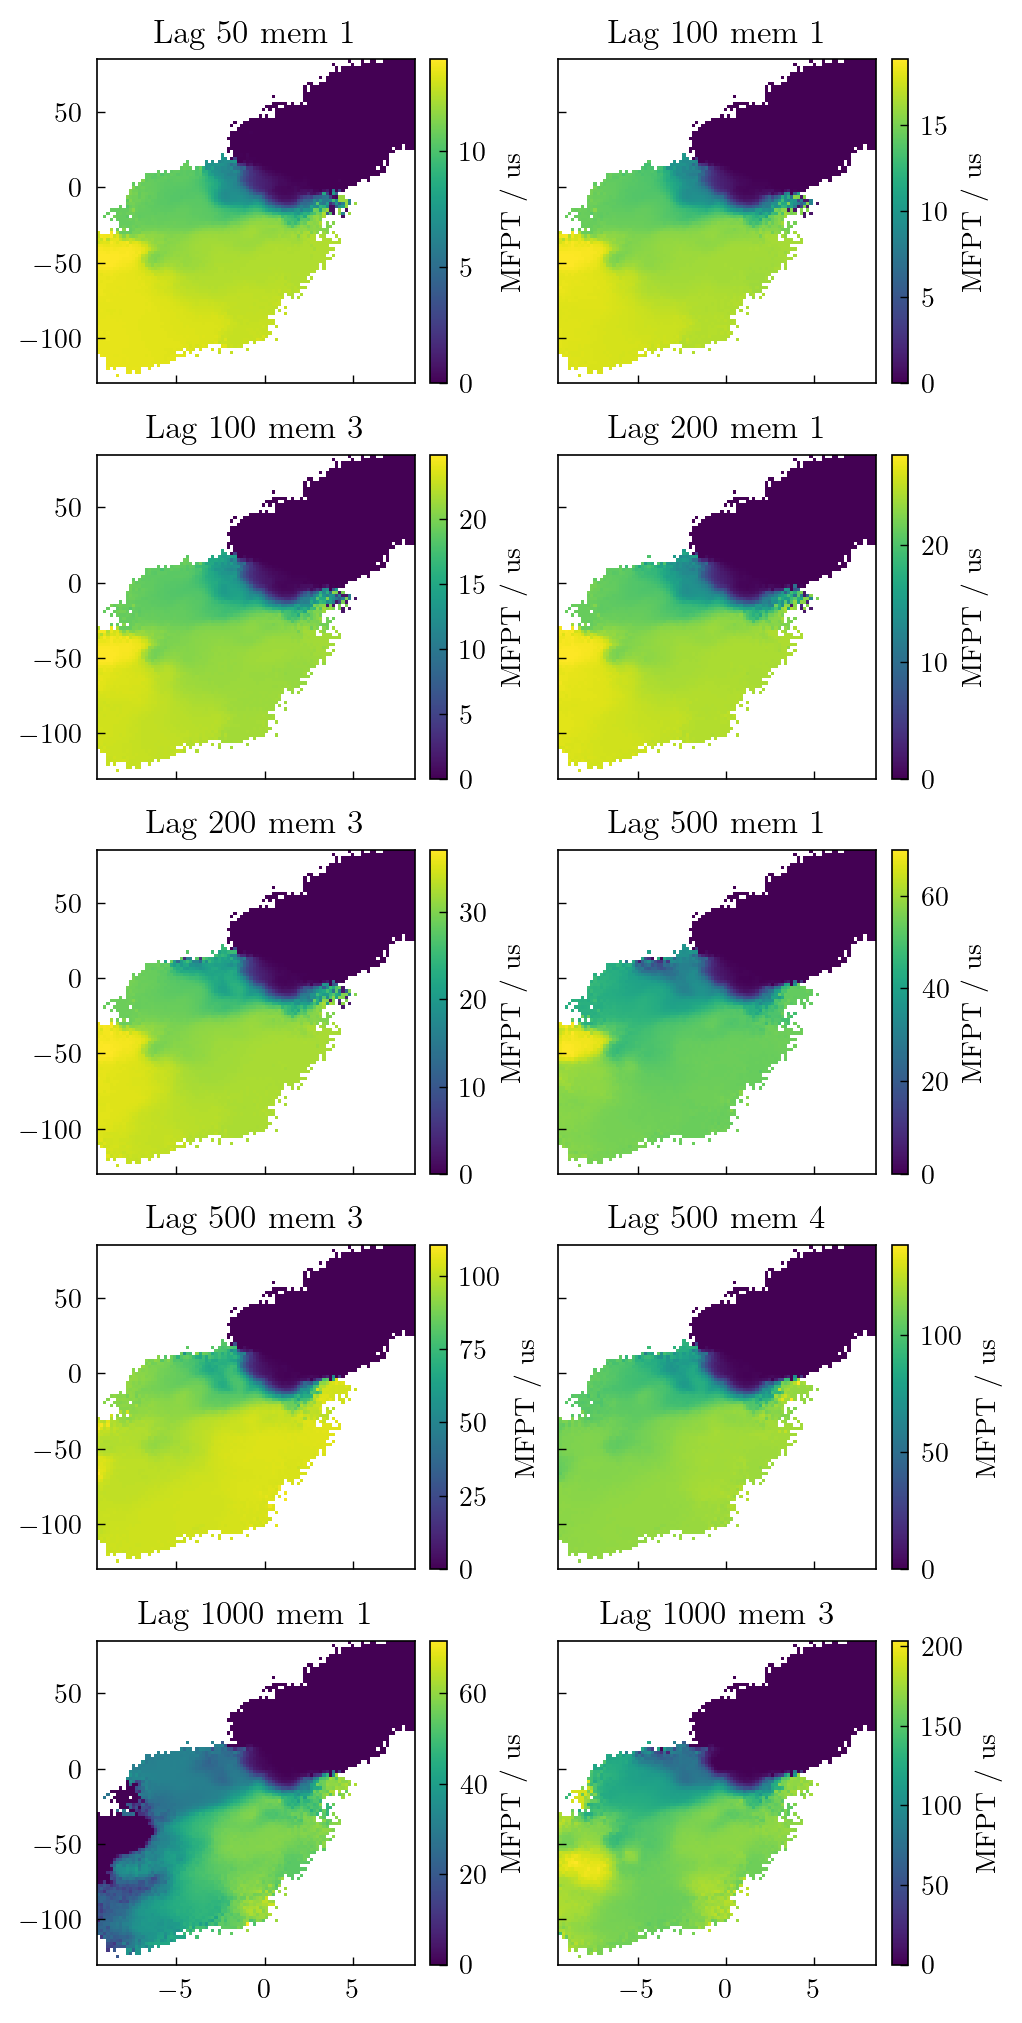

In [12]:
f, axs = plt.subplots(5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

for (lag, mem), m, ax in zip(results.keys(), results.values(), axs.flat):
    dist_trajs = [t[:-lag, 0] for t in cv_trajs]
    rot_trajs = [t[:-lag, 1] for t in cv_trajs]
    w_delay = [t[:-lag] for t in weights[0]]
    mfpt_delay = []
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt_delay.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
    pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001, vmin=0)
    cb = plt.colorbar(pc, ax=ax)
    cb.set_label("MFPT / us")
    ax.set_title(f"Lag {lag} mem {mem}")

In [13]:
np.save(f"{DATA_DIR}/mfpt_lag500_mem3_bigstate.npy", results[(500, 3)])

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [14]:
for (lag, mem), m in zip(results.keys(), results.values()):
    print(f"Lag {lag} mem {mem}")
    mfpt_down = np.concatenate(m)[down_ids]
    weight_down = np.concatenate(weights[0])[down_ids]
    print(np.mean(mfpt_down) * 0.0001)
    print(np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down))

Lag 50 mem 1
13.04957718055728
13.049640818523004
Lag 100 mem 1
17.263078683707775
17.262975973426816
Lag 100 mem 3
22.320148662386348
22.319707840036195
Lag 200 mem 1
25.418945461090978
25.418692817026024
Lag 200 mem 3
33.569382846010264
33.5689593517633
Lag 500 mem 1
55.26191526657632
55.26050882059726
Lag 500 mem 3
101.00486007230168
101.00604362301507
Lag 500 mem 4
114.43719307391707
114.4405240872228
Lag 1000 mem 1
33.83648798676727
33.84130331156524
Lag 1000 mem 3
165.75947505592924
165.7330399264178


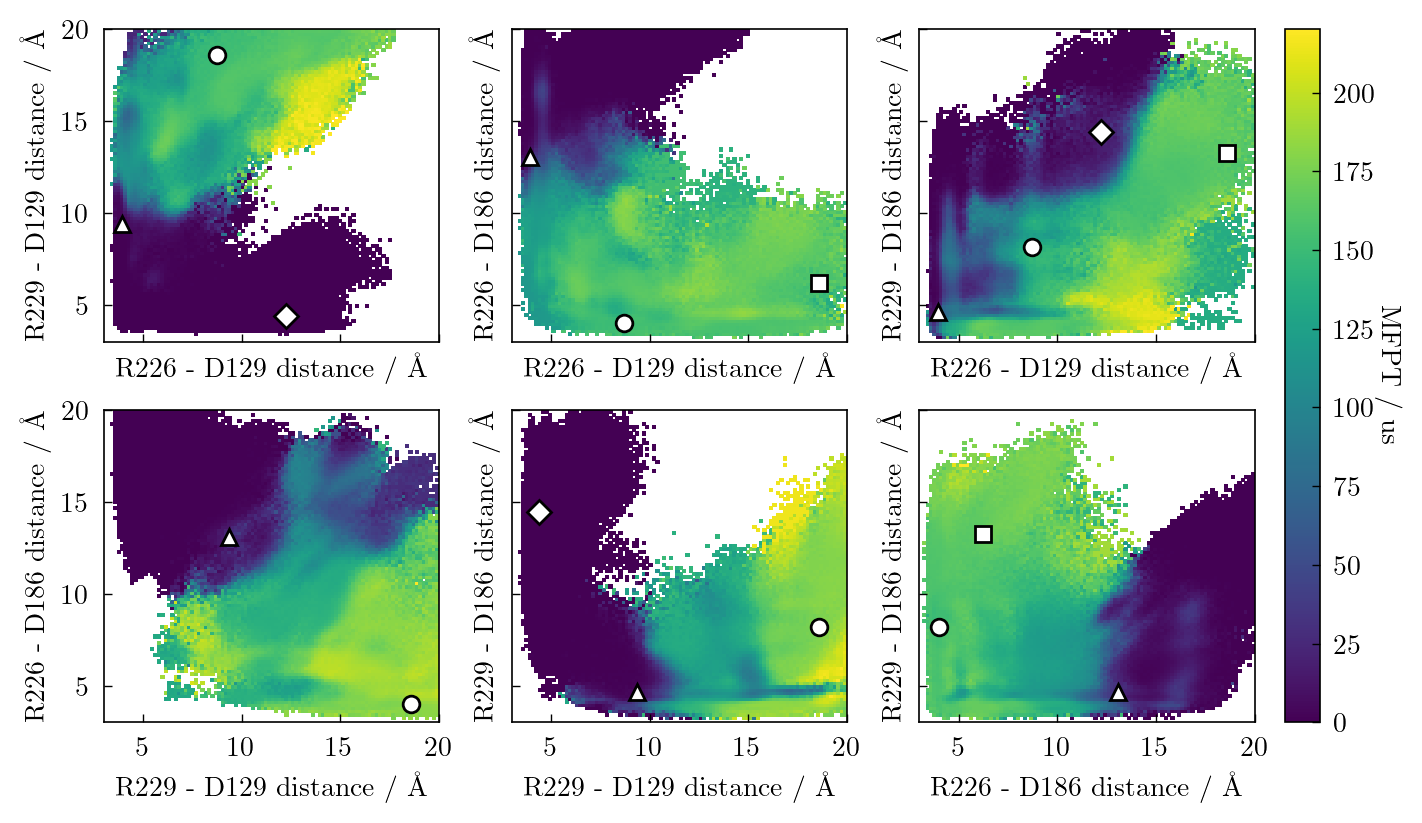

In [25]:
f, axes = plt.subplots(2, 3, figsize=(7, 4), sharex=True, sharey=True, dpi=200, constrained_layout=True)
sb1_lim = (3, 20)
sb2_lim = (3, 20)
if len(sb1_lim) == 2 and len(sb2_lim) == 2:
    sb1_lim = [sb1_lim] * 6
    sb2_lim = [sb2_lim] * 6

bins = 100

sb_ids = [42, 48, 47, 53]
sb_models = plotting.get_sb_models(centroids=True)
mfpt = results[(500, 3)]
for (sb1, sb2), ax, lim1, lim2 in zip(combinations(sb_ids, 2), axes.flat, sb1_lim, sb2_lim):
    traj_1 = [traj[:-lag, sb1] * 10 for traj in sb_trajs]
    traj_2 = [traj[:-lag, sb2] * 10 for traj in sb_trajs]
    xlim = np.linspace(*lim1, bins + 1)
    ylim = np.linspace(*lim2, bins + 1)
    for d, t in zip(in_domain, m):
        stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
        mfpt.append(t[stop_times])
    mfpt_bin = extq.projection.average2d(traj_1, traj_2, mfpt_delay, w_delay, xlim, ylim)
    h = ax.pcolor(xlim, ylim, mfpt_bin.T * 1e-4, vmin=0)
    ax.set_xlabel(f"{util.sb_label(sb1)} distance / $\\textrm{{\AA}}$")
    ax.set_ylabel(f"{util.sb_label(sb2)} distance / $\\textrm{{\AA}}$")
    ax.set_xlim(lim1)
    ax.set_ylim(lim2)
    plotting.plot_models(ax, sb_models[:, [sb1, sb2]] * 10, ms=6)

cb = f.colorbar(h, ax=axes[:, -1])
cb.set_label("MFPT / us", rotation=-90, labelpad=10)